In [1]:
import pandas as pd
import numpy as np
import itertools as it

import pickle as pcl

from scipy.spatial.distance import cdist

import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

from palettable.tableau import GreenOrange_12
cmap = GreenOrange_12.hex_colors

from collections import Counter

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import MeanShift

In [2]:
import hightolowz

from protocluster_completeness_purity import cluster_stats

In [3]:
epsilon = 0.1
c = 2.97 * 10**8 # m s^-1

In [4]:
gals_z6p42_sfr = pd.read_csv('data/r200/henriques2015a_z6p42_sfr_r200.csv',skiprows=107, skipfooter=1, engine='python')
gals_z5p03_sfr = pd.read_csv('data/r200/henriques2015a_z5p03_sfr_r200.csv',skiprows=107, skipfooter=1, engine='python')
gals_z3p95_sfr = pd.read_csv('data/r200/henriques2015a_z3p95_sfr_r200.csv',skiprows=107, skipfooter=1, engine='python')
gals_z3p10_sfr = pd.read_csv('data/r200/henriques2015a_z3p10_sfr_r200.csv',skiprows=107, skipfooter=1, engine='python')
gals_z2p07_sfr = pd.read_csv('data/r200/henriques2015a_z2p07_sfr_r200.csv',skiprows=107, skipfooter=1, engine='python')

In [5]:
gals_z6p42_mstar = pd.read_csv('data/r200/henriques2015a_z6p42_mstar_r200.csv',skiprows=107, skipfooter=1, engine='python')
gals_z5p03_mstar = pd.read_csv('data/r200/henriques2015a_z5p03_mstar_r200.csv',skiprows=107, skipfooter=1, engine='python')
gals_z3p95_mstar = pd.read_csv('data/r200/henriques2015a_z3p95_mstar_r200.csv',skiprows=107, skipfooter=1, engine='python')
gals_z3p10_mstar = pd.read_csv('data/r200/henriques2015a_z3p10_mstar_r200.csv',skiprows=107, skipfooter=1, engine='python')
gals_z2p07_mstar = pd.read_csv('data/r200/henriques2015a_z2p07_mstar_r200.csv',skiprows=107, skipfooter=1, engine='python')

In [6]:
gals_z7p57_sfr = pd.read_csv('data/r200/henriques2015a_z7p57_sfr_r200.csv',skiprows=107, skipfooter=1, engine='python')
gals_z7p57_mstar = pd.read_csv('data/r200/henriques2015a_z7p57_mstar_r200.csv',skiprows=107, skipfooter=1, engine='python')
gals_z8p93_sfr = pd.read_csv('data/r200/henriques2015a_z8p93_sfr_r200.csv',skiprows=107, skipfooter=1, engine='python')
gals_z8p93_mstar = pd.read_csv('data/r200/henriques2015a_z8p93_mstar_r200.csv',skiprows=107, skipfooter=1, engine='python')
gals_z9p72_sfr = pd.read_csv('data/r200/henriques2015a_z9p72_sfr_r200.csv',skiprows=107, skipfooter=1, engine='python')
gals_z9p72_mstar = pd.read_csv('data/r200/henriques2015a_z9p72_mstar_r200.csv',skiprows=107, skipfooter=1, engine='python')
gals_z10p57_sfr = pd.read_csv('data/r200/henriques2015a_z10p57_sfr_r200.csv',skiprows=107, skipfooter=1, engine='python')
gals_z10p57_mstar = pd.read_csv('data/r200/henriques2015a_z10p57_mstar_r200.csv',skiprows=107, skipfooter=1, engine='python')
gals_z11p51_sfr = pd.read_csv('data/r200/henriques2015a_z11p51_sfr_r200.csv',skiprows=107, skipfooter=1, engine='python')
gals_z11p51_mstar = pd.read_csv('data/r200/henriques2015a_z11p51_mstar_r200.csv',skiprows=107, skipfooter=1, engine='python')

In [7]:
frac_mstar = []
frac_mstar_10 = []
size_mstar = []
size_mstar10 = []
pcs_mstar = []
pcs_mstar10 = []
frac_agn_mstar = []
frac_agn_mstar_10 = []
for gals in [gals_z2p07_mstar, gals_z3p10_mstar, gals_z3p95_mstar, gals_z5p03_mstar, gals_z6p42_mstar, 
             gals_z7p57_mstar, gals_z8p93_mstar, gals_z9p72_mstar, gals_z10p57_mstar, gals_z11p51_mstar]:

    pc_mask = gals['z0_central_mcrit200'] >= 1e4
    mass_mask = gals['zn_stellarMass'] > 1

    Mdot = (gals['zn_quasarAccretionRate'] + gals['zn_radioAccretionRate']) * 1.989 * 10**30 / (365.25*24*60*60)

    Lbol = epsilon * Mdot * c**2 / 1e-7  # erg s^-1
    agn_mask = Lbol > 1e44
    
    frac_agn_mstar.append(np.sum(pc_mask & agn_mask))
    
    size_mstar.append(gals.shape[0])
    size_mstar10.append(gals[mass_mask].shape[0])
    pcs_mstar.append(gals[pc_mask].shape[0])
    pcs_mstar10.append(gals[pc_mask & mass_mask].shape[0])
    
    frac_mstar.append(float(gals[pc_mask].shape[0]) / gals.shape[0])
    
    if gals[mass_mask].shape[0] > 0:
        frac_mstar_10.append(float(gals[pc_mask & mass_mask].shape[0]) / gals[mass_mask].shape[0])
        frac_agn_mstar_10.append(np.sum(pc_mask &  mass_mask & agn_mask))
    else:
        frac_mstar_10.append(np.nan)
        frac_agn_mstar_10.append(np.nan)

    
frac_sfr = []
size_sfr = []
pcs_sfr = []
frac_agn_sfr = []
for gals in [gals_z2p07_sfr, gals_z3p10_sfr, gals_z3p95_sfr, gals_z5p03_sfr, gals_z6p42_sfr, 
             gals_z7p57_sfr, gals_z8p93_sfr, gals_z9p72_sfr, gals_z10p57_sfr, gals_z11p51_sfr]:
    
    Mdot = (gals['zn_quasarAccretionRate'] + gals['zn_radioAccretionRate']) * 1.989 * 10**30 / (365.25*24*60*60)

    Lbol = epsilon * Mdot * c**2 / 1e-7  # erg s^-1
    agn_mask = Lbol > 1e44
    
    frac_agn_sfr.append(np.sum((gals['z0_central_mcrit200'] > 1e4) & agn_mask))
    size_sfr.append(gals.shape[0])
    pcs_sfr.append(gals[gals['z0_central_mcrit200'] > 1e4].shape[0])
    frac_sfr.append(float(gals[gals['z0_central_mcrit200'] > 1e4].shape[0]) / gals.shape[0])

(0, 1)

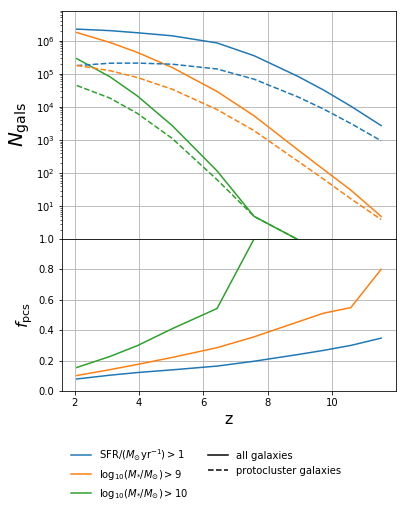

In [20]:
fig = plt.figure(figsize=(6, 7))

gs = gridspec.GridSpec(5, 1)

gs.update(hspace=0) # bottom = 0.57, top = 1, , wspace=0

ax1 = fig.add_subplot(gs[0:3,0])
ax2 = fig.add_subplot(gs[3:5,0])

z = [2.07, 3.10, 3.95, 5.03, 6.42, 7.57, 8.93, 9.72, 10.57, 11.51]

# Plot 1
ax1.semilogy(z, size_sfr, label='$\mathrm{SFR} > 1 M_{\odot} / \mathrm{yr}$', color='C0')
ax1.semilogy(z, size_mstar, label='$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 9$', color='C1')
ax1.semilogy(z, size_mstar10, label='$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 10$', color='C2')

ax1.semilogy(z, pcs_sfr, linestyle='dashed', color='C0')
ax1.semilogy(z, pcs_mstar, linestyle='dashed', color='C1')
ax1.semilogy(z, pcs_mstar10, linestyle='dashed', color='C2')

# ax1.semilogy(z, frac_agn_sfr, color='blue', linestyle='dotted')
# ax1.semilogy(z, frac_agn_mstar, color='green', linestyle='dotted')
# ax1.semilogy(z, frac_agn_mstar_10, color='red', linestyle='dotted')


ax1.set_xlabel('$z$', size=20)
ax1.set_ylabel('$N_{\mathrm{gals}}$', size=20)
ax1.set_xticklabels([])
ax1.set_ylim(1.05, 8e6)

# Plot 2
ax2.plot(z, frac_sfr)
ax2.plot(z, frac_mstar)
ax2.plot(z, frac_mstar_10)

line1 = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
line2 = plt.Line2D((0,1),(0,0), color='black', linestyle='dashed')
line3 = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

line_sfr = plt.Line2D((0,1),(0,0), color='C0', linestyle='solid')
line_mstar = plt.Line2D((0,1),(0,0), color='C1', linestyle='solid')
line_mstar10 = plt.Line2D((0,1),(0,0), color='C2', linestyle='solid')

ax2.legend(handles=[line_sfr, line_mstar, line_mstar10, line1, line2], #, line3], 
           labels=['$\mathrm{SFR} / (M_{\odot} \mathrm{yr}^{-1}) > 1$', 
                   '$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 9$',
                   '$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 10$',
                   'all galaxies','protocluster galaxies'],#,'protoclusters w/ AGN'], 
           loc=3, frameon=False, bbox_to_anchor=(0, -0.78), ncol=2)

ax2.set_ylabel('$f_{\mathrm{pcs}}$', size=16)#rotation=0,
ax2.set_xlabel('z', size=16)

ax1.grid()
ax2.grid()

ax2.set_ylim(0, 1)

# plt.savefig('../papers/hightolowz/images/pc_fractions.png', bbox_inches='tight', dpi=300)